In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the data 
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# Make a dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Print out the dataframe
# display(test_df)

# Show the test data 
# display(train_df)

pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

display(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def prepare_dataframe(df):
    new_df = df.copy(deep=True)
    
    new_df["Cabin"] = new_df["Cabin"].notnull().astype('int')
    
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    numeric_features = ["Age"]
    categorical_features = ["Embarked"]
    
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
    
    numeric_data = transformed_data[:, :len(numeric_features)]
    categorical_data = transformed_data[:, len(numeric_features):]
    
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
        
    new_df[categorical_encoded_features] = categorical_data 
    new_df[numeric_features] = numeric_data
    
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    new_df.drop(["Embarked", "Ticket", "Name", "PassengerId"],axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

0
177


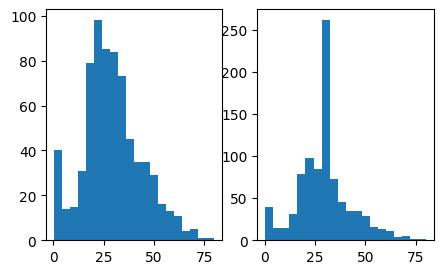

In [4]:
new_train_df = prepare_dataframe(train_df)
new_test_df = prepare_dataframe(test_df)

#Plotting histograms of the feature variables
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize = (5,3))

#print(len(train_df["Age"]), len(train_df_missing["Age"]))

ax[0].hist(train_df["Age"], bins=20);

ax[1].hist(new_train_df["Age"], bins=20);

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

In [5]:
new_train_df = prepare_dataframe(train_df)
new_test_df = prepare_dataframe(test_df)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

display(x_train)
display(x_test)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.000000,1,0,7.2500,0,0.0,0.0,1.0
1,1,1,38.000000,1,0,71.2833,1,1.0,0.0,0.0
2,3,1,26.000000,0,0,7.9250,0,0.0,0.0,1.0
3,1,1,35.000000,1,0,53.1000,1,0.0,0.0,1.0
4,3,0,35.000000,0,0,8.0500,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.000000,0,0,13.0000,0,0.0,0.0,1.0
887,1,1,19.000000,0,0,30.0000,1,0.0,0.0,1.0
888,3,1,29.699118,1,2,23.4500,0,0.0,0.0,1.0
889,1,0,26.000000,0,0,30.0000,1,1.0,0.0,0.0


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,3,0,34.50000,0,0,7.8292,0,0.0,1.0,0.0
1,3,1,47.00000,1,0,7.0000,0,0.0,0.0,1.0
2,2,0,62.00000,0,0,9.6875,0,0.0,1.0,0.0
3,3,0,27.00000,0,0,8.6625,0,0.0,0.0,1.0
4,3,1,22.00000,1,1,12.2875,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,3,0,30.27259,0,0,8.0500,0,0.0,0.0,1.0
414,1,1,39.00000,0,0,108.9000,1,1.0,0.0,0.0
415,3,0,38.50000,0,0,7.2500,0,0.0,0.0,1.0
416,3,0,30.27259,0,0,8.0500,0,0.0,0.0,1.0


In [6]:
importance = clf.feature_importances_
print(importance)

importance_dictionary = {x_train.columns[i] : importance[i] for i in range(len(importance)) }

importance_dictionary

[0.07487733 0.25221057 0.25476968 0.04491498 0.04002609 0.25177827
 0.04382441 0.01435147 0.00827612 0.01497109]


{'Pclass': 0.07487732566193707,
 'Sex': 0.2522105658459816,
 'Age': 0.2547696759986574,
 'SibSp': 0.04491498251570521,
 'Parch': 0.040026092355877056,
 'Fare': 0.2517782720709606,
 'Cabin': 0.04382441282513701,
 'Embarked_C': 0.014351465706739818,
 'Embarked_Q': 0.00827611780069002,
 'Embarked_S': 0.01497108921831418}

In [7]:
# Score the classifier
clf.score(x_train, y_train)


# Predict the test set survived values
# y_test_preds = clf.predict(x_test)

# Making a dictionary of the predictions
# test_survived_predictions_data = {"PassengerId" : new_test_df["PassengerId"], "Survived" : y_preds}

# Making a DataFrame of the predictions
# submission = pd.DataFrame(data = test_survived_predictions_data)

# Creating a CSV file to download to submit predictions
# submission.to_csv("/kaggle/working/my_titanic_submission.csv", index=False)

0.9865319865319865